## Modeling

In [1]:
import numpy as np
import rasterio
import os
from rasterio.plot import show
import torch 
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from sklearn.metrics import root_mean_squared_error, r2_score

xgb_device = ("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def create_data(BASE_PATH, year, resolution, site, model):

    if model == 1:
        depth_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")
        dem_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")

        with rasterio.open(depth_path) as depth_src:
            depth_data=depth_src.read(1)

        with rasterio.open(dem_path) as dem_src:
            dem_data=dem_src.read(1)
        
        df=pd.DataFrame({
            'depth': depth_data.ravel(),
            'dem' : dem_data.ravel(),
            'idx': np.arange(1, depth_data.ravel().shape[0]+1)
        })
    
    elif model == 2:

        depth_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")
        dem_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")
        amplitude_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "amplitude.tif")
        coherence=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "coherence.tif")
        inc_angle=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "inc_angle.tif")
        unw=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "unwrapped_phase.tif")
        wrap=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "wrapped_phase.tif")

        with rasterio.open(depth_path) as depth_src:
            depth_data=depth_src.read(1)

        with rasterio.open(dem_path) as dem_src:
            dem_data=dem_src.read(1)

        with rasterio.open(amplitude_path) as amp_src:
            ampl_data=amp_src.read(1)

        with rasterio.open(coherence) as co_src:
            co_data=co_src.read(1)


        with rasterio.open(inc_angle) as inc_src:
            inc_data=inc_src.read(1)

        with rasterio.open(unw) as unw_src:
            unw_data=unw_src.read(1)

        with rasterio.open(wrap) as wrap_src:
            wrap_data=wrap_src.read(1)

        df=pd.DataFrame({
            'depth': depth_data.ravel(),
            'dem' : dem_data.ravel(),
            'amplitude': ampl_data.ravel(),
            'coherence': co_data.ravel(),
            'inc_angle': inc_data.ravel(),
            'unw': unw_data.ravel(),
            'wrap': wrap_data.ravel(),
            'idx': np.arange(1, depth_data.ravel().shape[0]+1)
        })

    elif model == 3:

        depth_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")
        dem_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")
        amplitude_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "amplitude.tif")
        coherence=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "coherence.tif")
        inc_angle=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "inc_angle.tif")
        unw=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "unwrapped_phase.tif")
        wrap=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "wrapped_phase.tif")
        veg_height=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "veg_height.tif")

        with rasterio.open(depth_path) as depth_src:
            depth_data=depth_src.read(1)

        with rasterio.open(dem_path) as dem_src:
            dem_data=dem_src.read(1)

        with rasterio.open(amplitude_path) as amp_src:
            ampl_data=amp_src.read(1)

        with rasterio.open(coherence) as co_src:
            co_data=co_src.read(1)


        with rasterio.open(inc_angle) as inc_src:
            inc_data=inc_src.read(1)

        with rasterio.open(unw) as unw_src:
            unw_data=unw_src.read(1)

        with rasterio.open(wrap) as wrap_src:
            wrap_data=wrap_src.read(1)

        with rasterio.open(veg_height) as veg_src:
            veg_data=veg_src.read(1)

        df=pd.DataFrame({
            'depth': depth_data.ravel(),
            'dem' : dem_data.ravel(),
            'amplitude': ampl_data.ravel(),
            'coherence': co_data.ravel(),
            'inc_angle': inc_data.ravel(),
            'unw': unw_data.ravel(),
            'wrap': wrap_data.ravel(),
            'veg': veg_data.ravel(),
            'idx': np.arange(1, depth_data.ravel().shape[0]+1)
        })


    df_=df.replace(-9999.0, np.nan)

    clean_df = df_.dropna()
    # nulls = df_.loc[:, ['idx', 'depth']][df_.isna().any(axis=1)]
    nulls = df_.loc[df_.isna().any(axis=1)]
    final_df = clean_df.query('depth > 0')
    final_nulls = pd.concat([nulls, clean_df.query('depth < 0')])
    bounds = depth_src.bounds
    shape=depth_data.shape


    return final_df, final_nulls, bounds, shape
        

In [3]:
def return_original_shape(nulls, nonnulls, shape, preds=False):


    if preds == True:
        to_extract='depth'
    else:
        to_extract='pred_depth'

    conc = pd.concat([nulls, nonnulls]).filter(items=['idx', to_extract]).sort_values(by='idx')

    return conc.depth.values.reshape(shape)

In [4]:
def plot_raster(data, bounds=None, clim=(0, 5), cmap='magma', nodata=None):
    """
    Plot a raster with specified color limits and colormap
    
    Parameters:
    -----------
    data : str or numpy.ndarray
        Either path to the raster file or a 2D numpy array
    bounds : tuple, optional
        Bounds in format (left, bottom, right, top). Required if data is array
    clim : tuple
        Color limits (min, max) for visualization
    cmap : str
        Matplotlib colormap name
    nodata : float, optional
        No data value if passing array directly
    """
    if isinstance(data, str):
        # If data is a file path
        with rasterio.open(data) as src:
            raster_data = src.read(1)
            bounds = src.bounds
            nodata = src.nodata
    else:
        # If data is already a matrix
        raster_data = data
        if bounds is None:
            # If no bounds provided, use pixel coordinates
            bounds = (0, 0, data.shape[1], data.shape[0])
    
    # Mask nodata, inf and nan values
    if nodata is not None:
        mask = (raster_data == nodata)
    else:
        mask = np.zeros_like(raster_data, dtype=bool)
    
    mask = mask | np.isinf(raster_data) | np.isnan(raster_data)
    masked_data = np.ma.masked_array(raster_data, mask)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    plt.imshow(masked_data, 
              cmap=cmap, 
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]], 
              aspect='auto')
    
    # Set color limits
    plt.clim(clim[0], clim[1])
    
    # Add colorbar
    plt.colorbar()
    
    plt.xlabel('Easting [m]')
    plt.ylabel('Northing [m]')
    plt.show()

# Usage examples:
# 1. With file path:
# plot_raster('path/to/veg_height.tif', clim=(0, 5), cmap='magma')

# 2. With numpy array:
# matrix = np.random.rand(100, 100)
# bounds = (0, 0, 1000, 1000)  # example bounds
# plot_raster(depth_data, bounds=depth_src.bounds, clim=(0, 3), cmap='magma', nodata=-9999.0)

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def analyze_coherence(coherence, y_true, y_pred):
   """
   Calculate and plot RMSE for different coherence ranges.
   
   Parameters:
   -----------
   coherence : array-like
       Coherence values
   y_true : array-like 
       True snow depth values
   y_pred : array-like
       Predicted snow depth values
   """
   # Define coherence ranges 
   ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
   
   # Store results
   rmse_values = []
   sample_counts = []
   
   # Calculate RMSE for each coherence range
   for low, high in ranges:
       mask = (coherence >= low) & (coherence < high)
       
       if np.sum(mask) > 0:
           rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
           n_samples = np.sum(mask)
       else:
           rmse = np.nan
           n_samples = 0
           
       rmse_values.append(rmse)
       sample_counts.append(n_samples)
   
   # Plotting
   fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
   
   # Define bin centers for plotting
   bin_centers = [0.1, 0.3, 0.5, 0.7, 0.9]
   
   # Plot RMSE vs Coherence
   ax1.plot(bin_centers, rmse_values, 'o-', color='blue')
   ax1.set_xlabel('Coherence')
   ax1.set_ylabel('RMSE (m)')
   ax1.grid(True)
   ax1.set_title('RMSE vs Coherence')
   ax1.set_xlim(0, 1)
   
   # Plot sample distribution
   ax2.bar(bin_centers, sample_counts, width=0.15)
   ax2.set_xlabel('Coherence')
   ax2.set_ylabel('Number of Samples')
   ax2.set_title('Sample Distribution')
   ax2.grid(True)
   ax2.set_xlim(0, 1)
   
   plt.tight_layout()
   
   return rmse_values, sample_counts

# Example usage:
# rmse_by_coherence, samples_by_coherence = analyze_coherence(coherence, true_depth, predicted_depth)

In [6]:
def evaluate_model(
    y_true, 
    y_pred, 
    site,
    res
) -> pd.DataFrame:

    
    RMSE = root_mean_squared_error(y_true=y_true, y_pred=y_pred)
    MBE  = np.mean(y_pred - y_true)
    RSQ  = r2_score(y_true=y_true, y_pred=y_pred)
    name_to_print = f'{site}_{res}'
    score_df = pd.DataFrame({
        name_to_print: [RMSE, MBE, RSQ]
    }, index = ['RMSE', 'MBE', 'RSQ'])
    
    return score_df

In [7]:
xgb_params = {
    "sampling_method": "gradient_based",
    'objective': 'reg:squarederror',
    "min_child_weight": 30,
    'learning_rate': 0.05,
    'tree_method': 'hist',
    'booster': 'gbtree',
    'device': xgb_device,
    'max_depth': 0,
    "subsample": 1,
    "max_bin":5096,
    "seed": 42
}

In [8]:
BASE_PATH = '/home/habeeb/insar_idaho/uavsar-lidar-ml-project2/data/Processed_Data'

## Banner

* 100 m
* Model 3

In [9]:
year, site, resolution = '2020', 'Banner', 100
final_df, final_nulls, bounds, shape=create_data(BASE_PATH=BASE_PATH, year=year, resolution=resolution, site=site, model=3)

X_train, X_val, y_train, y_val = train_test_split(
    final_df.drop(['depth', 'idx'], axis=1), final_df.depth, test_size=0.3, random_state=42
)

In [10]:
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train model
model_banner_100 = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=1000,
    # evals=[(dtrain_full, 'train'), (dval, 'val')],
    # early_stopping_rounds=50,
    verbose_eval=False
)

## Evaluate

* Using Grand Mesa's Hyperparameter

In [11]:
train_pred = model_banner_100.predict(dtrain_full)
val_pred = model_banner_100.predict(dval)

train_eval=evaluate_model(y_train, train_pred, 'Train_Banner', 100)
test_eval=evaluate_model(y_val, val_pred, 'Test_Banner', 100)

display(pd.concat([train_eval, test_eval], axis=1))

,Train_Banner_100,Test_Banner_100
RMSE,1.200989e-02,0.172592
MBE,-1.013285e-07,0.000331
RSQ,9.987980e-01,0.756129


* importance

In [12]:
feature_importance = pd.DataFrame(
    data = {
        'feature': X_train.columns,
        'importance': model_banner_100.get_score(importance_type='gain').values()
    }
).sort_values(by='importance', ascending=False)

feature_importance

,feature,importance
0,dem,0.156528
6,veg,0.060218
2,coherence,0.028622
1,amplitude,0.027465
3,inc_angle,0.023206
4,unw,0.013894
5,wrap,0.009157


* Coherence Analysis

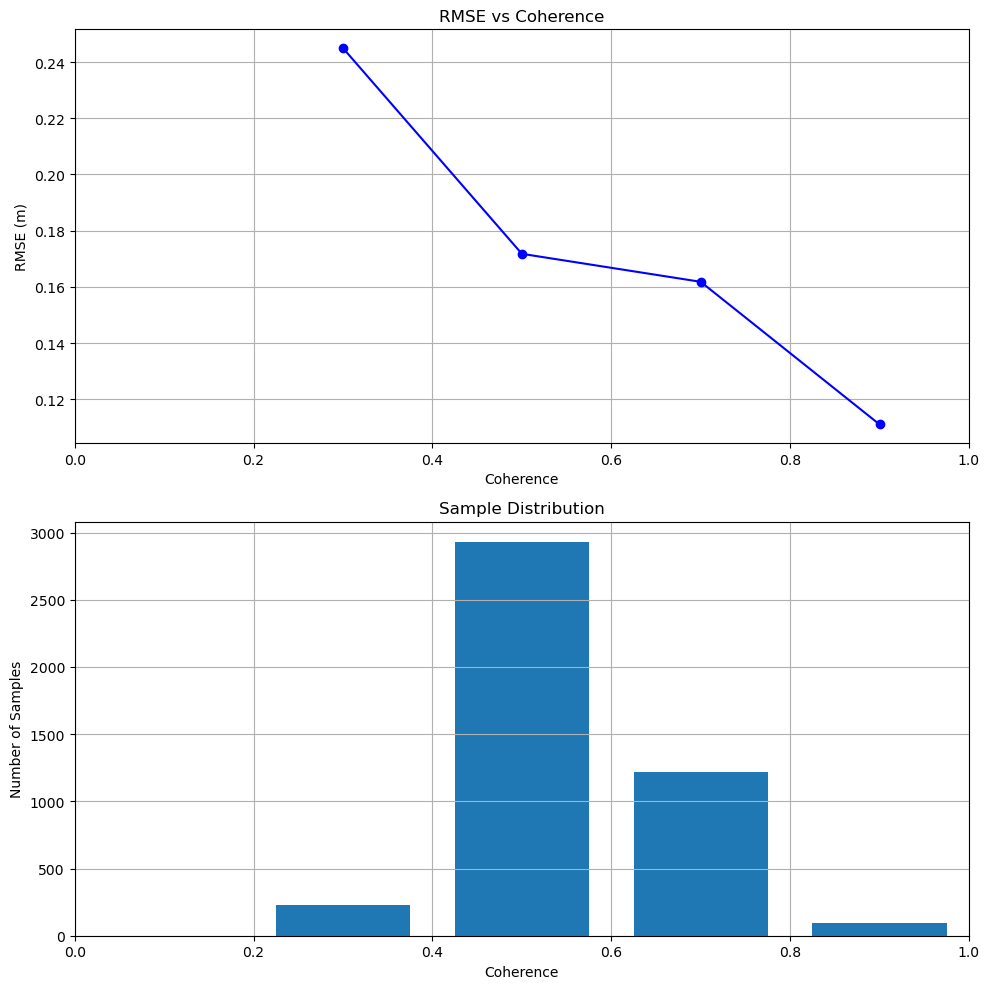

In [13]:
rmse_by_coherence, samples_by_coherence = analyze_coherence(X_val.coherence, y_val, val_pred)

In [14]:
samples_by_coherence

[0, np.int64(228), np.int64(2933), np.int64(1218), np.int64(97)]

In [15]:
rmse_by_coherence

[nan,
 np.float64(0.24494389947550524),
 np.float64(0.17178858947376513),
 np.float64(0.16182727282267412),
 np.float64(0.11110620381235821)]

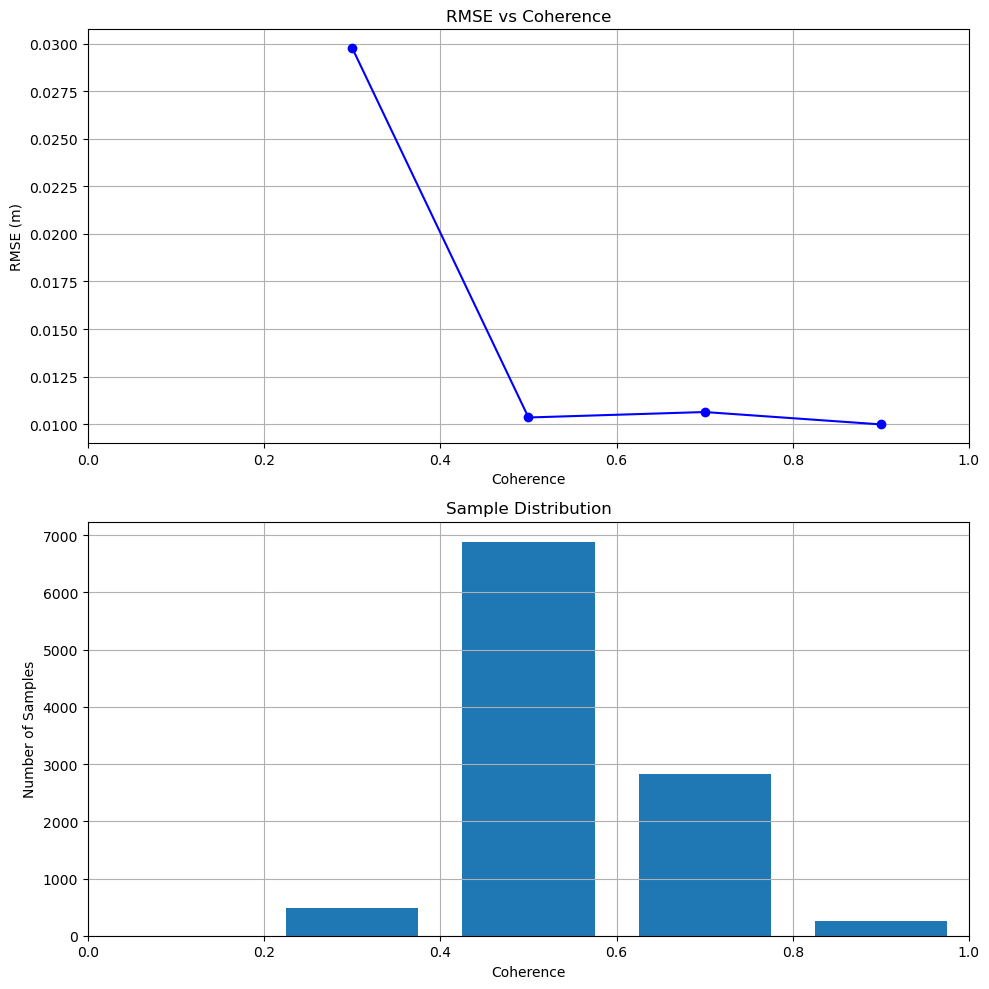

In [16]:
rmse_by_coherence, samples_by_coherence = analyze_coherence(X_train.coherence, y_train, train_pred)

* Vegetation vs open

In [17]:
veg_pred_ana=pd.DataFrame({
    'true_depth': y_val,
    'pred_depth': val_pred,
    'veg_ht': X_val.veg
})

veg_pred_ana.head()

,true_depth,pred_depth,veg_ht
12490,2.081978,2.118766,2.160147
7357,1.333528,1.308325,3.463654
20409,1.297991,1.223731,5.956718
9177,1.076737,1.130681,5.810845
14227,1.722753,1.405828,2.267916


In [21]:
open_areas = veg_pred_ana.query('veg_ht < 0.5')

veg_areas = veg_pred_ana.query('veg_ht >= 0.5')

open_eval=evaluate_model(open_areas.true_depth, open_areas.pred_depth, 'Open', 100)
veg_eval=evaluate_model(veg_areas.true_depth, veg_areas.pred_depth, 'Veg', 100)

display(pd.concat([open_eval, veg_eval], axis=1))

,Open_100,Veg_100
RMSE,0.199106,0.171195
MBE,-0.016343,0.001143
RSQ,0.876649,0.738410


* Pred 2021

In [24]:
year, site, resolution = '2021', 'Banner', 100
final_df_, final_nulls_, bounds_, shape_=create_data(BASE_PATH=BASE_PATH, year=year, resolution=resolution, site=site, model=3)

banner21=xgb.DMatrix(final_df_.drop(['depth', 'idx'], axis=1))

In [25]:
banner21_pred = model_banner_100.predict(banner21)

banner21_eval=evaluate_model(final_df_.depth, banner21_pred, 'Banner_2021', 100)

display(banner21_eval)

,Banner_2021_100
RMSE,0.363685
MBE,0.102522
RSQ,0.073563


* pred dry

* pred Mores

* Test Model Transferability

In [21]:
UAVSAR_AND_VEGETATION_HEIGHT_FEATURES=[
    'coherence',
    'amplitude',
    'vegetation_ht',
    'wrapped_phase',
    'elevation',
    'incidence_angle',
    'unwrapped_phase'
]

new_x_val=X_val.rename(columns={
    'dem': 'elevation',
    'inc_angle': 'incidence_angle',
    'unw': 'unwrapped_phase',
    'wrap': 'wrapped_phase',
    'veg': 'vegetation_ht'
}
)

new_x_train=X_train.rename(columns={
    'dem': 'elevation',
    'inc_angle': 'incidence_angle',
    'unw': 'unwrapped_phase',
    'wrap': 'wrapped_phase',
    'veg': 'vegetation_ht'
}
)

new_dval = xgb.DMatrix(new_x_val.filter(items=UAVSAR_AND_VEGETATION_HEIGHT_FEATURES), label=y_val)
new_dtrain = xgb.DMatrix(new_x_train.filter(items=UAVSAR_AND_VEGETATION_HEIGHT_FEATURES), label=y_train)

In [22]:
xgb_model2 = xgb.Booster()
xgb_model2.load_model("/home/habeeb/insar_idaho/uavsar-lidar-ml-project2/gm_model/uavsar_veg_model.ubj") 

In [23]:
train_pred = xgb_model2.predict(new_dtrain)
val_pred = xgb_model2.predict(new_dval)

train_eval=evaluate_model(train_pred, y_train, 'Train_Banner', 100)
test_eval=evaluate_model(val_pred, y_val, 'Test_Banner', 100)

display(pd.concat([train_eval, test_eval], axis=1))

,Train_Banner_100,Test_Banner_100
RMSE,0.772454,0.769580
MBE,0.689375,0.684944
RSQ,-13.302489,-13.661976


* Train 2021

In [27]:
year, site, resolution = '2021', 'Banner', 100
final_df, final_nulls, bounds, shape=create_data(BASE_PATH=BASE_PATH, year=year, resolution=resolution, site=site, model=3)

X_train, X_val, y_train, y_val = train_test_split(
    final_df.drop(['depth', 'idx'], axis=1), final_df.depth, test_size=0.3, random_state=42
)

In [28]:
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train model
model_banner_100 = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=1000,
    # evals=[(dtrain_full, 'train'), (dval, 'val')],
    # early_stopping_rounds=50,
    verbose_eval=False
)

In [29]:
train_pred = model_banner_100.predict(dtrain_full)
val_pred = model_banner_100.predict(dval)

train_eval=evaluate_model(y_train, train_pred, 'Train_Banner', 100)
test_eval=evaluate_model(y_val, val_pred, 'Test_Banner', 100)

display(pd.concat([train_eval, test_eval], axis=1))

,Train_Banner_100,Test_Banner_100
RMSE,1.000510e-02,0.205089
MBE,1.902356e-07,-0.000503
RSQ,9.992948e-01,0.709347


In [30]:
feature_importance = pd.DataFrame(
    data = {
        'feature': X_train.columns,
        'importance': model_banner_100.get_score(importance_type='gain').values()
    }
).sort_values(by='importance', ascending=False)

feature_importance

,feature,importance
0,dem,0.160252
3,inc_angle,0.070901
6,veg,0.055342
2,coherence,0.042959
1,amplitude,0.022744
4,unw,0.017419
5,wrap,0.013012


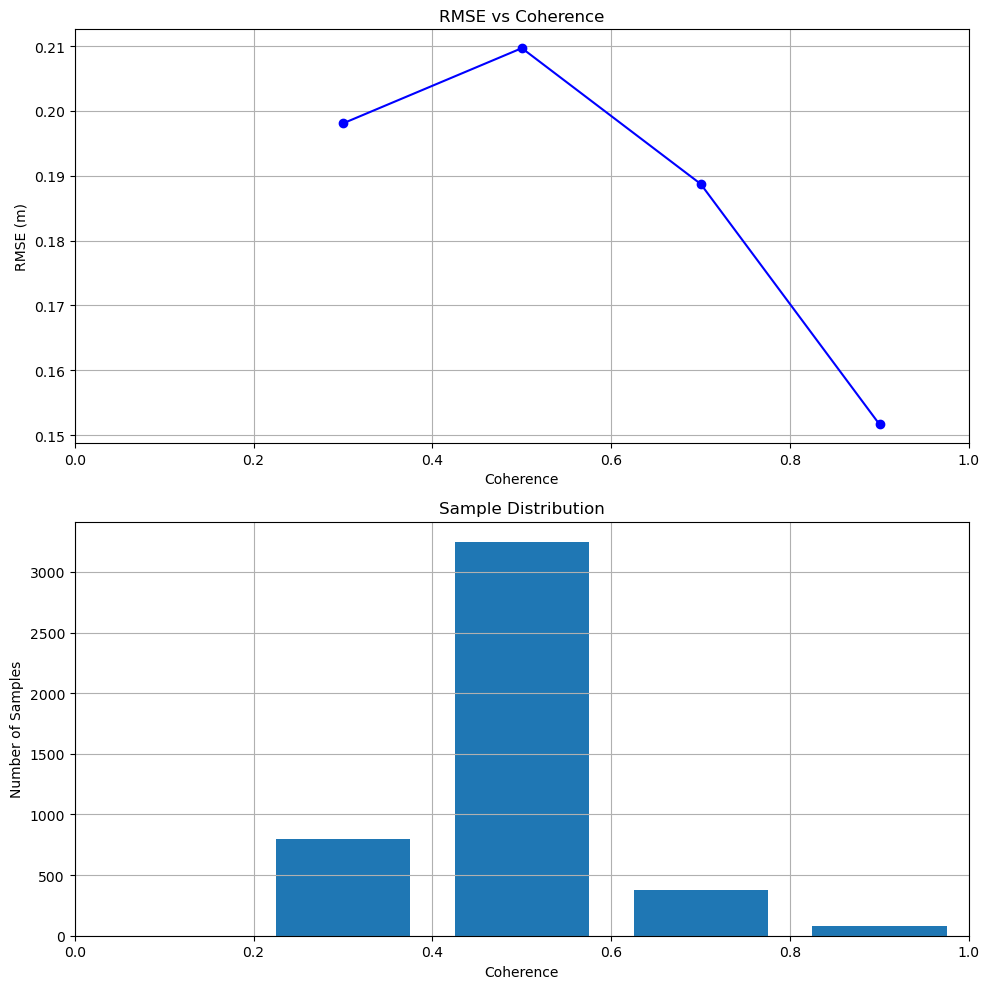

In [31]:
rmse_by_coherence, samples_by_coherence = analyze_coherence(X_val.coherence, y_val, val_pred)

In [1]:
import sys

sys.path.append('..')

In [2]:
from insarml.learning_curve import create_learning_curves, plot_learning_curves, plot_resolution_comparison
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [3]:
sites = ['Banner', 'Dry', 'Mores']
years = ['2020', '2021']

all_results = []

for site in sites:
    for year in years:
        # Skip Dry Creek 2021 as it doesn't exist
        if site == 'Dry' and year == '2021':
            continue
            
        print(f"\nProcessing {site} {year}")
        try:
            # Create learning curves and store results
            results = create_learning_curves(site=site, year=year)
            all_results.append(results)
            
        except Exception as e:
            print(f"Error processing {site} {year}: {str(e)}")
            continue

# Create and save comparison plot
if all_results:
    comparison_fig = plot_resolution_comparison(all_results)
    comparison_path = os.path.join('/home/habeeb/insar_idaho/uavsar-lidar-ml-project2/data/Processed_Data', 
                                    'Learning_Curves', 
                                    f'resolution_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
    comparison_fig.savefig(comparison_path, dpi=300, bbox_inches='tight')
    plt.close(comparison_fig)


Processing Banner 2020

Processing 3m resolution
Total pixels: 27900385
Valid pixels (after depth filtering): 18531338
DEM range: 1614.46 to 2840.35
Depth range: 0.00 to 12.29
Negative depths removed: 8969
NaN depths removed: 21981

Training splits for 3m:
Total samples: 18531338
Training samples: 12971936 (70%)
Validation samples: 1853134 (10%)
Test samples: 3706268 (20%)

Processing training size: 10.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 20.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 30.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 40.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 50.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 60.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 70.0%
Train RMSE: 0.374m
Validation RMSE: 0.374m

Processing training size: 80.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing tra

In [3]:
sites = ['Banner', 'Dry', 'Mores']
years = ['2020', '2021']

for site in sites:
    for year in years:
        # Skip Dry Creek 2021 as it doesn't exist
        if site == 'Dry' and year == '2021':
            continue
            
        print(f"\nProcessing {site} {year}")
        try:
            # Create learning curves
            curves_data = create_learning_curves(site=site, year=year)
            
            # Plot results
            fig = plot_learning_curves(curves_data, site, year)
            plt.close()
            
        except Exception as e:
            print(f"Error processing {site} {year}: {str(e)}")
            continue


Processing Banner 2020

Processing 3m resolution
Total pixels: 27900385
Valid pixels (after depth filtering): 18531338
DEM range: 1614.46 to 2840.35
Depth range: 0.00 to 12.29
Negative depths removed: 8969
NaN depths removed: 21981

Training splits for 3m:
Total samples: 18531338
Training samples: 12971936 (70%)
Validation samples: 1853134 (10%)
Test samples: 3706268 (20%)

Processing training size: 10.0%
Train RMSE: 0.375m
Validation RMSE: 0.375m

Processing training size: 20.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 30.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 40.0%
Train RMSE: 0.375m
Validation RMSE: 0.375m

Processing training size: 50.0%
Train RMSE: 0.375m
Validation RMSE: 0.375m

Processing training size: 60.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing training size: 70.0%
Train RMSE: 0.375m
Validation RMSE: 0.375m

Processing training size: 80.0%
Train RMSE: 0.374m
Validation RMSE: 0.375m

Processing tra

In [164]:
import numpy as np
import rasterio
import os
from rasterio.plot import show
import torch 
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

xgb_device = ("cuda" if torch.cuda.is_available() else "cpu")

In [214]:
BASE_PATH = '/home/habeeb/insar_idaho/uavsar-lidar-ml-project2/data/Processed_Data'
year, site, resolution = '2020', 'Banner', 100

depth_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")
dem_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")
amplitude_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "amplitude.tif")
coherence=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "coherence.tif")
inc_angle=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "inc_angle.tif")
unw=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "unwrapped_phase.tif")
wrap=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "wrapped_phase.tif")
veg_height=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "veg_height.tif")

In [225]:
final_df, final_nulls, bounds, shape=create_data(BASE_PATH, '2020', 100, 'Banner', 3)

In [227]:
final_nulls

,depth,dem,amplitude,coherence,inc_angle,unw,wrap,veg,idx
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...
24910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24911
24911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24912
24912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24913
24913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24914


In [232]:
shape

(165, 151)

In [237]:
def return_original_shape(nulls, nonnulls, shape, preds=False):


    if preds == True:
        to_extract='depth'
    else:
        to_extract='pred_depth'

    conc = pd.concat([nulls, nonnulls]).filter(items=['idx', to_extract]).sort_values(by='idx')

    return conc.depth.values.reshape(shape)

In [235]:
zz=pd.concat([final_nulls, final_df]).filter(items=['idx', 'depth']).sort_values(by='idx').depth.values.reshape(shape)
zz

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [224]:
def create_data(BASE_PATH, year, resolution, site, model):

    if model == 1:
        depth_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")
        dem_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")

        with rasterio.open(depth_path) as depth_src:
            depth_data=depth_src.read(1)

        with rasterio.open(dem_path) as dem_src:
            dem_data=dem_src.read(1)
        
        df=pd.DataFrame({
            'depth': depth_data.ravel(),
            'dem' : dem_data.ravel(),
            'idx': np.arange(1, depth_data.ravel().shape[0]+1)
        })
    
    elif model == 2:

        depth_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")
        dem_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")
        amplitude_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "amplitude.tif")
        coherence=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "coherence.tif")
        inc_angle=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "inc_angle.tif")
        unw=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "unwrapped_phase.tif")
        wrap=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "wrapped_phase.tif")

        with rasterio.open(depth_path) as depth_src:
            depth_data=depth_src.read(1)

        with rasterio.open(dem_path) as dem_src:
            dem_data=dem_src.read(1)

        with rasterio.open(amplitude_path) as amp_src:
            ampl_data=amp_src.read(1)

        with rasterio.open(coherence) as co_src:
            co_data=co_src.read(1)


        with rasterio.open(inc_angle) as inc_src:
            inc_data=inc_src.read(1)

        with rasterio.open(unw) as unw_src:
            unw_data=unw_src.read(1)

        with rasterio.open(wrap) as wrap_src:
            wrap_data=wrap_src.read(1)

        df=pd.DataFrame({
            'depth': depth_data.ravel(),
            'dem' : dem_data.ravel(),
            'amplitude': ampl_data.ravel(),
            'coherence': co_data.ravel(),
            'inc_angle': inc_data.ravel(),
            'unw': unw_data.ravel(),
            'wrap': wrap_data.ravel(),
            'idx': np.arange(1, depth_data.ravel().shape[0]+1)
        })

    elif model == 3:

        depth_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")
        dem_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")
        amplitude_path=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "amplitude.tif")
        coherence=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "coherence.tif")
        inc_angle=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "inc_angle.tif")
        unw=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "unwrapped_phase.tif")
        wrap=os.path.join(BASE_PATH, year, site, f"{resolution}m", "UAVSAR", "wrapped_phase.tif")
        veg_height=os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "veg_height.tif")

        with rasterio.open(depth_path) as depth_src:
            depth_data=depth_src.read(1)

        with rasterio.open(dem_path) as dem_src:
            dem_data=dem_src.read(1)

        with rasterio.open(amplitude_path) as amp_src:
            ampl_data=amp_src.read(1)

        with rasterio.open(coherence) as co_src:
            co_data=co_src.read(1)


        with rasterio.open(inc_angle) as inc_src:
            inc_data=inc_src.read(1)

        with rasterio.open(unw) as unw_src:
            unw_data=unw_src.read(1)

        with rasterio.open(wrap) as wrap_src:
            wrap_data=wrap_src.read(1)

        with rasterio.open(veg_height) as veg_src:
            veg_data=veg_src.read(1)

        df=pd.DataFrame({
            'depth': depth_data.ravel(),
            'dem' : dem_data.ravel(),
            'amplitude': ampl_data.ravel(),
            'coherence': co_data.ravel(),
            'inc_angle': inc_data.ravel(),
            'unw': unw_data.ravel(),
            'wrap': wrap_data.ravel(),
            'veg': veg_data.ravel(),
            'idx': np.arange(1, depth_data.ravel().shape[0]+1)
        })


    df_=df.replace(-9999.0, np.nan)

    clean_df = df_.dropna()
    # nulls = df_.loc[:, ['idx', 'depth']][df_.isna().any(axis=1)]
    nulls = df_.loc[df_.isna().any(axis=1)]
    final_df = clean_df.query('depth > 0')
    final_nulls = pd.concat([nulls, clean_df.query('depth < 0')])
    bounds = depth_src.bounds
    shape=depth_data.shape


    return final_df, final_nulls, bounds, shape
        

In [171]:
cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
depth,17195470.0,1.506490,0.443250,-10.874733,1.209651,1.464469,1.760153,12.293973
dem,17195470.0,2288.062012,194.208252,1614.464355,2147.322510,2285.731079,2432.862061,2840.354004
amplitude,17195470.0,0.166271,0.095204,0.012504,0.102149,0.150312,0.210278,2.548370
coherence,17195470.0,0.556444,0.174768,0.002434,0.433072,0.562981,0.685672,0.988830
inc_angle,17195470.0,1.036220,0.252264,0.181835,0.856112,1.030528,1.204368,1.974254
unw,17195470.0,-0.394297,0.881449,-9.611614,-0.990528,-0.494287,0.139135,8.422506
wrap,17195470.0,-0.334552,1.039597,-3.141580,-1.040611,-0.419542,0.321783,3.141552
veg,17195470.0,2.804862,3.847373,0.019959,0.249461,1.315596,3.852668,45.867119


In [215]:
with rasterio.open(depth_path) as depth_src:
    depth_data=depth_src.read(1)

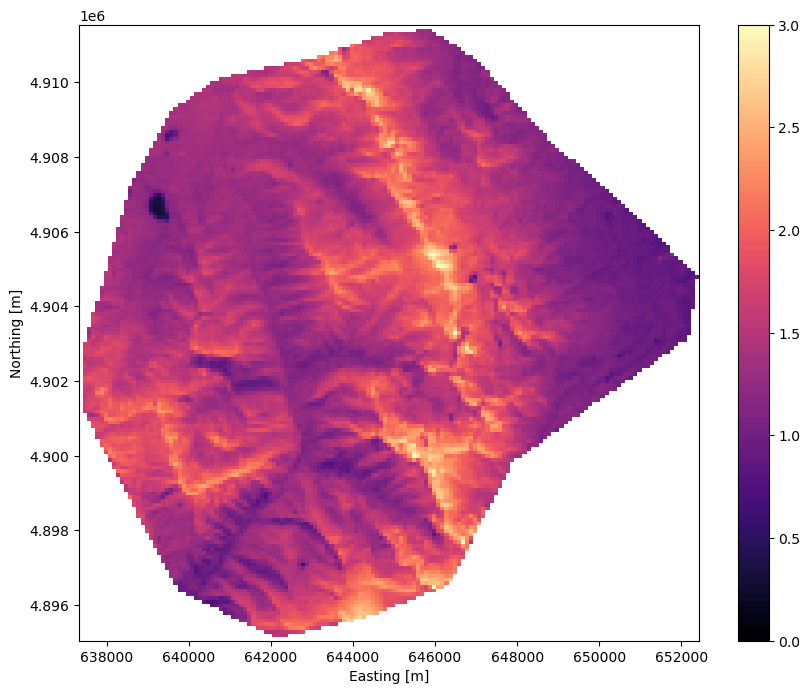

In [216]:
def plot_raster(data, bounds=None, clim=(0, 5), cmap='magma', nodata=None):
    """
    Plot a raster with specified color limits and colormap
    
    Parameters:
    -----------
    data : str or numpy.ndarray
        Either path to the raster file or a 2D numpy array
    bounds : tuple, optional
        Bounds in format (left, bottom, right, top). Required if data is array
    clim : tuple
        Color limits (min, max) for visualization
    cmap : str
        Matplotlib colormap name
    nodata : float, optional
        No data value if passing array directly
    """
    if isinstance(data, str):
        # If data is a file path
        with rasterio.open(data) as src:
            raster_data = src.read(1)
            bounds = src.bounds
            nodata = src.nodata
    else:
        # If data is already a matrix
        raster_data = data
        if bounds is None:
            # If no bounds provided, use pixel coordinates
            bounds = (0, 0, data.shape[1], data.shape[0])
    
    # Mask nodata, inf and nan values
    if nodata is not None:
        mask = (raster_data == nodata)
    else:
        mask = np.zeros_like(raster_data, dtype=bool)
    
    mask = mask | np.isinf(raster_data) | np.isnan(raster_data)
    masked_data = np.ma.masked_array(raster_data, mask)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    plt.imshow(masked_data, 
              cmap=cmap, 
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]], 
              aspect='auto')
    
    # Set color limits
    plt.clim(clim[0], clim[1])
    
    # Add colorbar
    plt.colorbar()
    
    plt.xlabel('Easting [m]')
    plt.ylabel('Northing [m]')
    plt.show()

# Usage examples:
# 1. With file path:
# plot_raster('path/to/veg_height.tif', clim=(0, 5), cmap='magma')

# 2. With numpy array:
# matrix = np.random.rand(100, 100)
# bounds = (0, 0, 1000, 1000)  # example bounds
plot_raster(depth_data, bounds=depth_src.bounds, clim=(0, 3), cmap='magma', nodata=-9999.0)

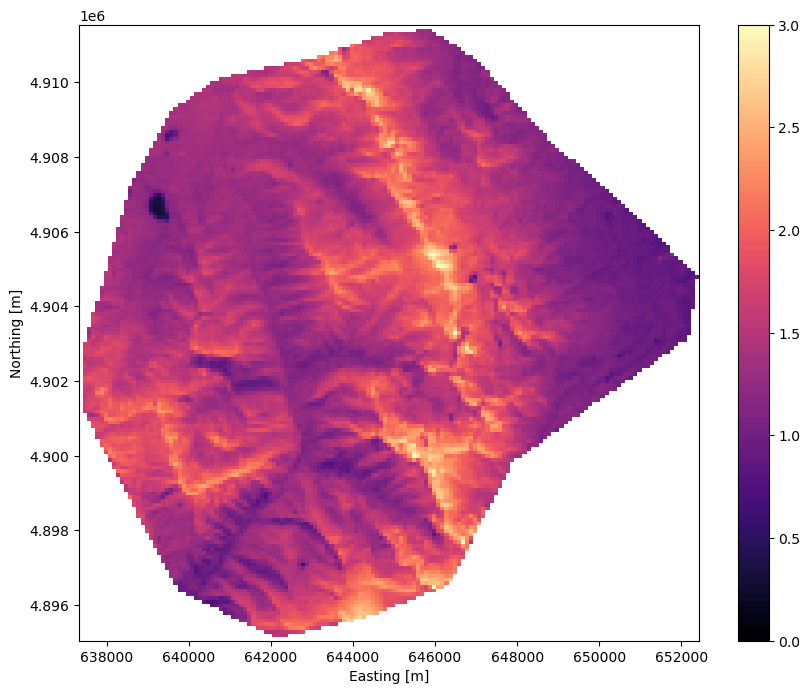

In [236]:
plot_raster(zz, bounds=depth_src.bounds, clim=(0, 3), cmap='magma', nodata=-9999.0)

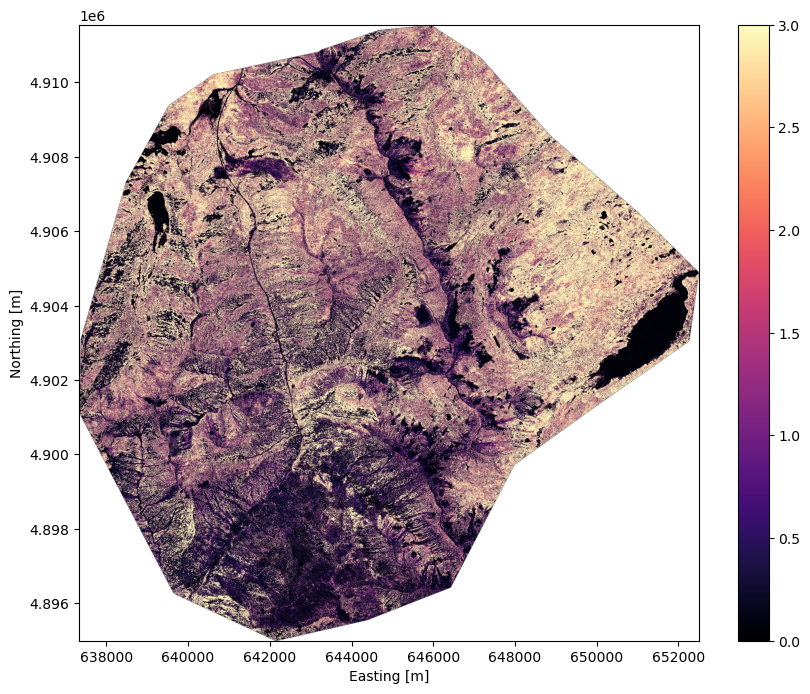

In [188]:
def plot_raster(path, clim=(0, 5), cmap='magma'):
    """
    Plot a raster with specified color limits and colormap
    
    Parameters:
    -----------
    path : str
        Path to the raster file
    clim : tuple
        Color limits (min, max) for visualization
    cmap : str
        Matplotlib colormap name
    """
    with rasterio.open(path) as src:
        # Read data
        data = src.read(1)
        bounds = src.bounds
        
        # Mask nodata, inf and nan values
        mask = (data == src.nodata) | np.isinf(data) | np.isnan(data)
        masked_data = np.ma.masked_array(data, mask)
        
        # Create plot
        plt.figure(figsize=(10, 8))
        plt.imshow(masked_data, 
                  cmap=cmap, 
                  extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], 
                  aspect='auto')
        
        # Set color limits
        plt.clim(clim[0], clim[1])
        
        # Add colorbar
        plt.colorbar()
        
        plt.xlabel('Easting [m]')
        plt.ylabel('Northing [m]')
        plt.show()

# Usage example:
plot_raster(veg_height, clim=(0, 3), cmap='magma')

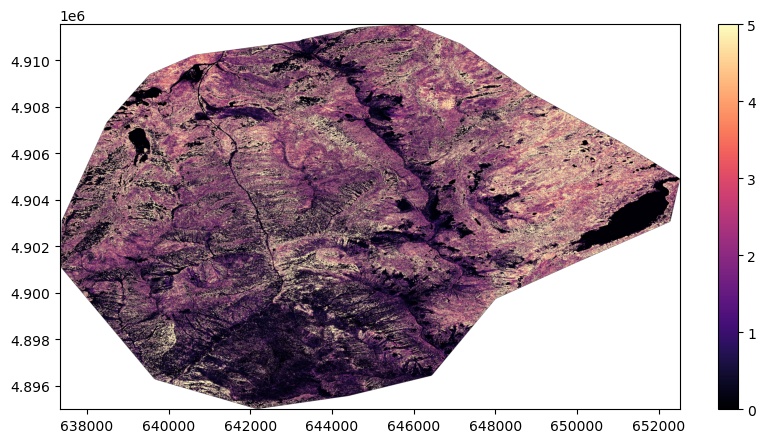

In [ ]:
with rasterio.open(veg_height) as veg_src:
    veg_data=veg_src.read(1)
bounds = veg_src.bounds
mask = (veg_data == veg_src.nodata) | np.isinf(veg_data) | np.isnan(veg_data)
data = np.ma.masked_array(veg_data, mask)
plt.imshow(data, cmap='magma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], aspect='auto')
plt.clim(0, 5)
plt.colorbar()
plt.show()

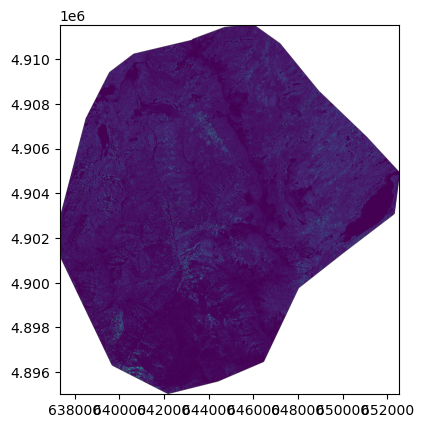

<Axes: >

In [165]:
show(rasterio.open(veg_height))

In [162]:
veg_src.transform

Affine(3.0, 0.0, 637332.5,
       0.0, -3.0, 4911543.0)

In [122]:
df=pd.DataFrame({
    'depth': depth_data.ravel(),
    'dem' : dem_data.ravel(),
    'amplitude': ampl_data.ravel(),
    'coherence': co_data.ravel(),
    'inc_angle': inc_data.ravel(),
    'unw': unw_data.ravel(),
    'wrap': wrap_data.ravel(),
    'veg': veg_data.ravel()
})

df.head()

,depth,dem,amplitude,coherence,inc_angle,unw,wrap,veg
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [123]:
cleaned_df=(
    df
    .replace(-9999.0, np.nan)
    .dropna()
)

cleaned_df.head()

,depth,dem,amplitude,coherence,inc_angle,unw,wrap,veg
7917,1.094079,2160.106689,0.150050,0.639436,1.018000,-1.523219,-1.656258,1.600806
7918,1.106325,2159.072754,0.147038,0.796831,1.019208,-1.724730,-1.511455,1.476235
7919,0.980116,2158.234619,0.157792,0.702115,1.020409,-1.491773,-1.769560,6.909469
7920,0.984087,2157.539307,0.149963,0.628091,1.021293,-1.491773,-1.769560,8.123765
7921,0.927034,2157.000732,0.122944,0.586176,1.021820,-1.504014,-1.608331,18.863878


In [124]:
cleaned_df.shape

(17195470, 8)

In [154]:
xgb_params = {
    "sampling_method": "gradient_based",
    'objective': 'reg:squarederror',
    "min_child_weight": 30,
    'learning_rate': 0.05,
    'tree_method': 'hist',
    'booster': 'gbtree',
    'device': xgb_device,
    'max_depth': 0,
    "subsample": 1,
    "max_bin":5096,
    "seed": 42
}

X_train, X_val, y_train, y_val = train_test_split(
    cleaned_df.drop('depth', axis=1), cleaned_df.depth, test_size=0.3, random_state=42
)

In [155]:
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train model
model_new = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=100,
    # evals=[(dtrain_full, 'train'), (dval, 'val')],
    # early_stopping_rounds=50,
    verbose_eval=False
)

In [156]:
# Train model
model_new = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=100,
    # evals=[(dtrain_full, 'train'), (dval, 'val')],
    # early_stopping_rounds=50,
    verbose_eval=False
)

In [158]:
from sklearn.metrics import root_mean_squared_error as rmse, r2_score

train_pred = model_new.predict(dtrain_full)
val_pred = model_new.predict(dval)

r2_score(y_true=y_train, y_pred=train_pred), r2_score(y_true=y_val, y_pred=val_pred)

(0.8982051014900208, 0.6886926889419556)

In [139]:
# Train model
model_new = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=100,
    # evals=[(dtrain_full, 'train'), (dval, 'val')],
    # early_stopping_rounds=50,
    verbose_eval=False
)

In [140]:
from sklearn.metrics import root_mean_squared_error as rmse, r2_score

train_pred = model_new.predict(dtrain_full)
val_pred = model_new.predict(dval)

r2_score(y_true=y_train, y_pred=train_pred), r2_score(y_true=y_val, y_pred=val_pred)

(0.8982051014900208, 0.6886926889419556)

In [141]:
rmse(y_true=y_train, y_pred=train_pred), rmse(y_true=y_val, y_pred=val_pred)

(0.14142246544361115, 0.24730229377746582)

In [137]:
from sklearn.metrics import root_mean_squared_error as rmse, r2_score

train_pred = model_new.predict(dtrain_full)
val_pred = model_new.predict(dval)

r2_score(y_true=y_train, y_pred=train_pred), r2_score(y_true=y_val, y_pred=val_pred)

(0.8027264475822449, 0.656991720199585)

In [138]:
rmse(y_true=y_train, y_pred=train_pred), rmse(y_true=y_val, y_pred=val_pred)

(0.19687466323375702, 0.25958868861198425)

In [133]:
from sklearn.metrics import root_mean_squared_error as rmse, r2_score

train_pred = model.predict(dtrain_full)
val_pred = model.predict(dval)

r2_score(y_true=y_train, y_pred=train_pred), r2_score(y_true=y_val, y_pred=val_pred)

(0.9998425245285034, 0.7365092039108276)

In [134]:
rmse(y_true=y_train, y_pred=train_pred), rmse(y_true=y_val, y_pred=val_pred)

(0.005562666803598404, 0.2275182157754898)

In [135]:
model.save_model('../id_models/banner_full_2020_3m.ubj')

In [13]:
cleaned_df.drop('depth', axis=1)

,dem,amplitude,coherence,inc_angle,unw,wrap
2861,2157.907715,0.157017,0.662509,1.023081,-1.491773,-1.769560
2862,2157.428955,0.131735,0.616563,1.023849,-1.504014,-1.608331
7917,2160.106689,0.150050,0.639436,1.018000,-1.523219,-1.656258
7918,2159.072754,0.147038,0.796831,1.019208,-1.724730,-1.511455
7919,2158.234619,0.157792,0.702115,1.020409,-1.491773,-1.769560
...,...,...,...,...,...,...
27886822,2357.153809,0.071252,0.396775,1.577798,-0.430874,-0.534319
27886823,2356.218994,0.071145,0.437004,1.593322,-0.430874,-0.534319
27886824,2355.198486,0.095989,0.535973,1.607185,-0.430874,-0.534319
27886825,2354.217041,0.120883,0.609764,1.620330,-0.496367,-1.464747


In [27]:
xgb_params = {
    "sampling_method": "gradient_based",
    'objective': 'reg:squarederror',
    "min_child_weight": 30,
    'learning_rate': 0.3,
    'tree_method': 'hist',
    'booster': 'gbtree',
    'device': xgb_device,
    'max_depth': 0,
    "subsample": 1,
    "max_bin":5096,
    "seed": 42
}

X_train, X_val, y_train, y_val = train_test_split(
    cleaned_df.drop('depth', axis=1), cleaned_df.depth, test_size=0.3, random_state=42
)

In [28]:
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [29]:
# Train model
model = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=1000,
    evals=[(dtrain_full, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=False
)

In [30]:
from sklearn.metrics import root_mean_squared_error as rmse, r2_score

train_pred = model.predict(dtrain_full)
val_pred = model.predict(dval)

r2_score(y_true=y_train, y_pred=train_pred), r2_score(y_true=y_val, y_pred=val_pred)

(0.9999896883964539, 0.7013280391693115)

In [40]:
full_preds_train=X_train.assign(preds=train_pred, true_depth=y_train)

In [35]:
full_preds=X_val.assign(preds=val_pred, true_depth=y_val)

In [37]:
full_preds.describe().T

,count,mean,std,min,25%,50%,75%,max
dem,5158645.0,2287.993164,194.154953,1614.555908,2147.265381,2285.725830,2432.744629,2839.990479
amplitude,5158645.0,0.166305,0.095214,0.012504,0.102194,0.150314,0.210295,2.548370
coherence,5158645.0,0.556499,0.174693,0.002434,0.433250,0.562981,0.685594,0.988311
inc_angle,5158645.0,1.036118,0.252272,0.186471,0.856013,1.030266,1.204252,1.970655
unw,5158645.0,-0.394407,0.881225,-9.611614,-0.990331,-0.493817,0.138742,8.422506
wrap,5158645.0,-0.334812,1.038996,-3.141580,-1.040421,-0.419575,0.321407,3.141552
preds,5158645.0,1.506219,0.375484,-2.663903,1.252467,1.467347,1.723274,8.919374
true_depth,5158645.0,1.506376,0.443391,-10.874733,1.209562,1.464272,1.759992,10.193415


In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def analyze_coherence_performance(y_true, y_pred, coherence, n_bins=10, plot=True):
    """
    Analyze model performance across different coherence ranges.
    
    Parameters:
    -----------
    y_true : array-like
        True snow depth values
    y_pred : array-like
        Predicted snow depth values
    coherence : array-like
        Coherence values
    n_bins : int
        Number of coherence bins
    plot : bool
        Whether to create a plot
        
    Returns:
    --------
    dict
        Dictionary containing bin edges and RMSE values
    """
    # Create coherence bins
    bin_edges = np.linspace(coherence.min(), coherence.max(), n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Initialize arrays for results
    rmse_values = []
    sample_counts = []
    
    # Calculate RMSE for each bin
    for i in range(n_bins):
        mask = (coherence >= bin_edges[i]) & (coherence < bin_edges[i+1])
        if np.sum(mask) > 0:  # Check if we have samples in this bin
            rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            rmse_values.append(rmse)
            sample_counts.append(np.sum(mask))
        else:
            rmse_values.append(np.nan)
            sample_counts.append(0)
    
    if plot:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
        
        # Plot RMSE vs Coherence
        ax1.plot(bin_centers, rmse_values, 'o-', color='blue')
        ax1.set_xlabel('Coherence')
        ax1.set_ylabel('RMSE (m)')
        ax1.grid(True)
        ax1.set_title('RMSE vs Coherence')
        
        # Plot sample count
        ax2.bar(bin_centers, sample_counts, width=(bin_edges[1]-bin_edges[0])*0.8)
        ax2.set_xlabel('Coherence')
        ax2.set_ylabel('Number of Samples')
        ax2.set_title('Sample Distribution Across Coherence Bins')
        ax2.grid(True)
        
        plt.tight_layout()
        
    results = {
        'bin_edges': bin_edges.tolist(),
        'bin_centers': bin_centers.tolist(),
        'rmse_values': rmse_values,
        'sample_counts': sample_counts,
        'mean_rmse': np.nanmean(rmse_values),
        'std_rmse': np.nanstd(rmse_values)
    }
    
    return results

# Example usage:
# results = analyze_coherence_performance(y_true, y_pred, coherence)

{'bin_edges': [0.005968544632196426,
  0.10425472259521484,
  0.20254088938236237,
  0.3008270561695099,
  0.3991132378578186,
  0.4973994195461273,
  0.595685601234436,
  0.6939718127250671,
  0.7922579646110535,
  0.8905441164970398,
  0.9888303279876709],
 'bin_centers': [0.055111631751060486,
  0.153397798538208,
  0.2516839802265167,
  0.34997016191482544,
  0.44825631380081177,
  0.5465425252914429,
  0.6448286771774292,
  0.7431148886680603,
  0.8414010405540466,
  0.9396872520446777],
 'rmse_values': [np.float64(0.004559264268799587),
  np.float64(0.0019069630113836165),
  np.float64(0.0016022899987898787),
  np.float64(0.0012977541789395393),
  np.float64(0.0012422437603531958),
  np.float64(0.001182749467092406),
  np.float64(0.0013527898751444823),
  np.float64(0.0014959946454167399),
  np.float64(0.0016634993068397606),
  np.float64(0.0027838552096943205)],
 'sample_counts': [np.int64(24921),
  np.int64(244957),
  np.int64(742128),
  np.int64(1371154),
  np.int64(2018333),


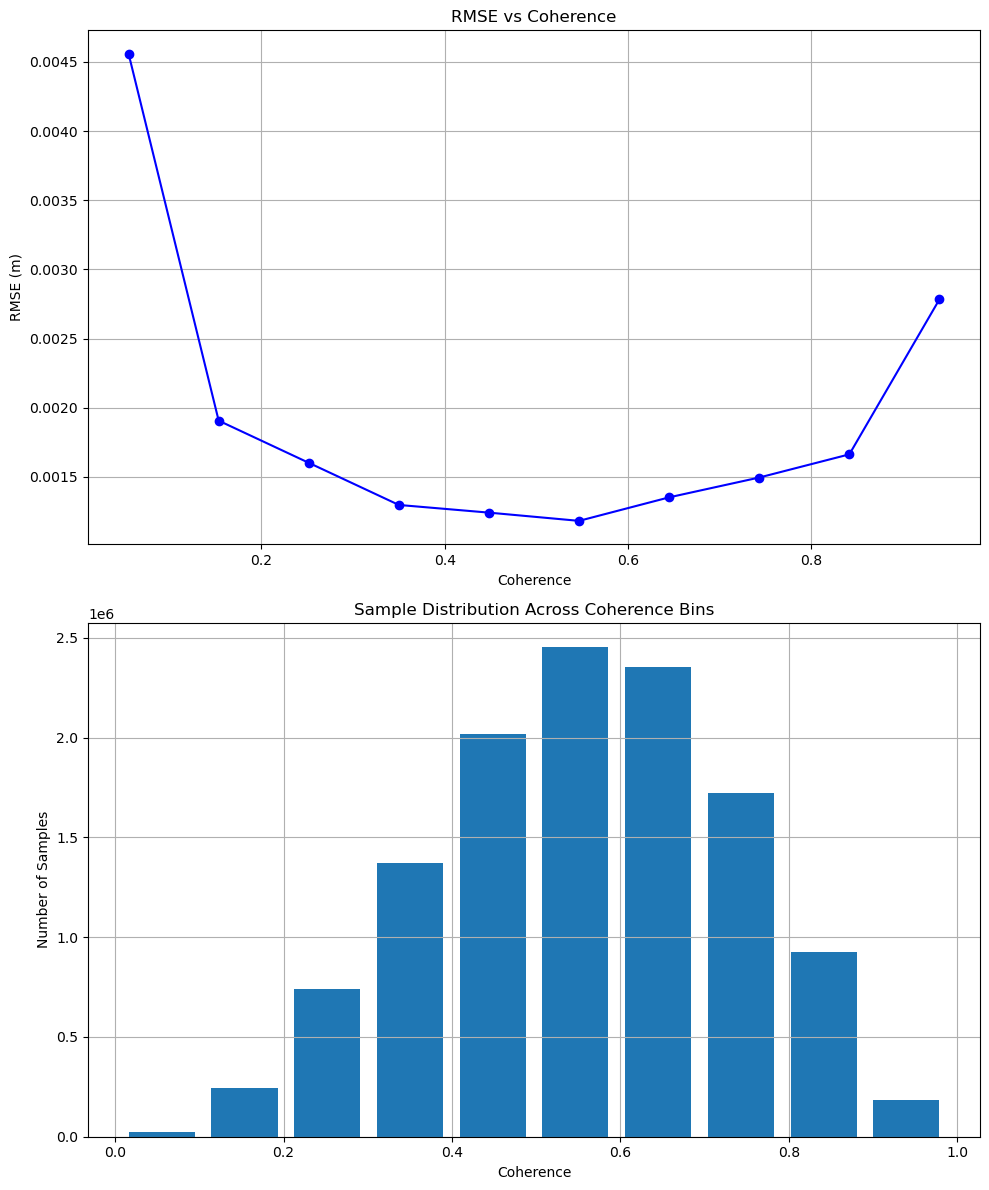

In [41]:
analyze_coherence_performance(full_preds_train.true_depth, full_preds_train.preds, full_preds_train.coherence)

{'bin_edges': [0.00243356847204268,
  0.10102126747369766,
  0.1996089667081833,
  0.2981966733932495,
  0.39678436517715454,
  0.49537205696105957,
  0.5939598083496094,
  0.6925475001335144,
  0.7911351919174194,
  0.8897228837013245,
  0.9883105754852295],
 'bin_centers': [0.05172741785645485,
  0.15031512081623077,
  0.248902827501297,
  0.347490519285202,
  0.44607821106910706,
  0.5446659326553345,
  0.6432536840438843,
  0.7418413162231445,
  0.8404290676116943,
  0.9390166997909546],
 'rmse_values': [np.float64(0.26648821534694617),
  np.float64(0.26405388744687547),
  np.float64(0.26405865593092936),
  np.float64(0.2529938664258267),
  np.float64(0.2454596099633068),
  np.float64(0.23912887212865624),
  np.float64(0.23772561061221886),
  np.float64(0.2392297611530384),
  np.float64(0.2296573369338771),
  np.float64(0.19456910756964751)],
 'sample_counts': [np.int64(9438),
  np.int64(100078),
  np.int64(310521),
  np.int64(582734),
  np.int64(862567),
  np.int64(1052429),
  np.

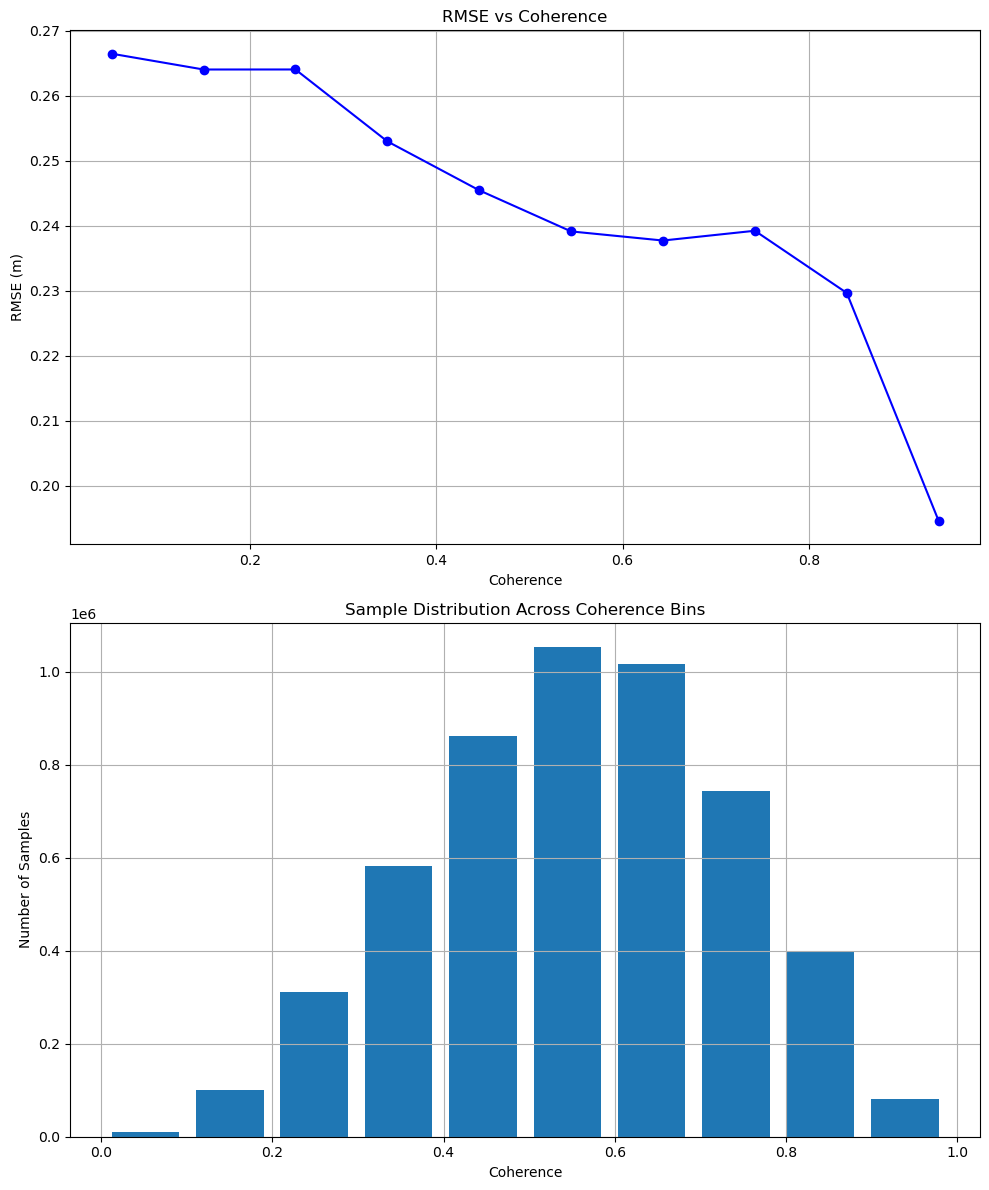

In [39]:
analyze_coherence_performance(full_preds.true_depth, full_preds.preds, full_preds.coherence)

In [31]:
from sklearn.metrics import root_mean_squared_error as rmse, r2_score

train_pred = model.predict(dtrain_full)
val_pred = model.predict(dval)

rmse(y_true=y_train, y_pred=train_pred), rmse(y_true=y_val, y_pred=val_pred)

(0.0014212039532139897, 0.24231719970703125)

In [27]:
with rasterio.open(unw) as unw_src:
    unw_data=unw_src.read(1)

In [30]:
pd.DataFrame(unw_data.flatten(), columns=['unw']).query('unw != -9999').dropna()

,unw
2856,-1.185263
2857,-1.523219
2858,-1.523219
2859,-1.724730
2860,-1.491773
...,...
27891885,-0.431718
27896937,-1.769736
27896938,-0.914150
27896939,-0.914150


In [2]:
def prepare_data(dem_path, depth_path):
    """Prepare data from rasters, handling nodata values, NaN, and negative depths."""
    with rasterio.open(dem_path) as dem_src, rasterio.open(depth_path) as depth_src:
        dem_data = dem_src.read(1)
        depth_data = depth_src.read(1)
        
        # Create masks for valid data
        dem_mask = (dem_data != dem_src.nodata) & (~np.isnan(dem_data))
        depth_mask = (depth_data != depth_src.nodata) & (~np.isnan(depth_data)) & (depth_data > 0)
        valid_mask = dem_mask & depth_mask
        
        # Get valid data
        X = dem_data[valid_mask].reshape(-1, 1)
        y = depth_data[valid_mask]
        
        # Store indices for reconstruction
        valid_idx = np.where(valid_mask)
        metadata = dem_src.meta.copy()
        
        print(f"Total pixels: {dem_data.size}")
        print(f"Valid pixels (after depth filtering): {len(X)}")
        print(f"DEM range: {np.min(X):.2f} to {np.max(X):.2f}")
        print(f"Depth range: {np.min(y):.2f} to {np.max(y):.2f}")
        print(f"Negative depths removed: {np.sum((depth_data <= 0) & (depth_data != depth_src.nodata))}")
        print(f"NaN depths removed: {np.sum(np.isnan(depth_data))}")
        
    return X.astype(np.float32), y.astype(np.float32), valid_idx, metadata

In [3]:
BASE_PATH = '/home/habeeb/insar_idaho/uavsar-lidar-ml-project2/data/Processed_Data'
year, site, resolution = '2020', 'Banner', 10

dem_path = os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "dem.tif")
depth_path = os.path.join(BASE_PATH, year, site, f"{resolution}m", "LiDAR", "snow_depth.tif")

In [4]:
depth=rasterio.open(depth_path)

In [4]:
X, y, valid_idx, metadata = prepare_data(dem_path, depth_path)

Total pixels: 2509118
Valid pixels: 1664184
DEM range: 1615.01 to 2839.30
Depth range: -2.44 to 7.93


In [6]:
xgb_params = {
    "sampling_method": "gradient_based",
    'objective': 'reg:squarederror',
    "min_child_weight": 30,
    'learning_rate': 0.3,
    'tree_method': 'hist',
    'booster': 'gbtree',
    'device': xgb_device,
    'max_depth': 0,
    "subsample": 1,
    "max_bin":5096,
    "seed": 42
}

In [15]:
X.ravel().shape

(1664184,)

In [7]:
df=pd.DataFrame({
    'dem': X.ravel(),
    'depth': y
})

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664184 entries, 0 to 1664183
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   dem     1664184 non-null  float32
 1   depth   1664184 non-null  float32
dtypes: float32(2)
memory usage: 12.7 MB


,dem,depth
0,2161.559082,1.212543
1,2161.089355,1.077715
2,2160.547607,1.067831
3,2158.271484,1.034903
4,2155.576172,1.151565


In [8]:
new_df=(
    df
    .query('depth > 0')
)

In [ ]:
new_df

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_df[['dem']], new_df['depth'], test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val[['dem']], y_train_val, test_size=0.125, random_state=42
)

In [10]:
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [32]:
train_sizes = np.linspace(0.1, 1.0, 10)

In [11]:
# Train model
model = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=1000,
    evals=[(dtrain_full, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=False
)

In [ ]:
from sklearn.metrics import root_mean_squared_error as rmse

train_pred = model.predict(dtrain_full)
val_pred = model.predict(dval)

rmse(y_true=y_train, y_pred=train_pred), rmse(y_true=y_val, y_pred=val_pred)

In [12]:
train_pred = model.predict(dtrain_full)
val_pred = model.predict(dval)

In [13]:
from sklearn.metrics import root_mean_squared_error as rmse

In [14]:
rmse(y_true=y_train, y_pred=train_pred)

0.3277320861816406

In [15]:
rmse(y_true=y_val, y_pred=val_pred)

0.3279380202293396

In [ ]:
# Get and prepare data
        X, y, valid_idx, metadata = prepare_data(dem_path, depth_path)
        
        # First split: 80% for training/validation, 20% held out for final testing
        train_val_idx, test_idx = train_test_split(
            np.arange(len(X)), test_size=0.2, random_state=42
        )
        
        # Second split: Split remaining 80% into 70% training, 10% validation
        train_idx, val_idx = train_test_split(
            train_val_idx, test_size=0.125, random_state=42
        )
        
        # Create DMatrix objects for full datasets
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_val = X[val_idx]
        y_val = y[val_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        
        dtrain_full = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

In [10]:
X

array([[2161.559 ],
       [2161.0894],
       [2160.5476],
       ...,
       [2362.5627],
       [2359.2646],
       [2355.5647]], dtype=float32)

In [7]:
dtrain=xgb.DMatrix(self.split['X_temp'][self.var], label=self.split['y_temp'])

'cuda'